<a href="https://colab.research.google.com/github/CristianViSa/TFM/blob/main/lstm_mejorada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports


In [12]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import datetime
import time
import keras.backend as K
import math
import pickle
from pathlib import Path

from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Bidirectional, Dropout, TimeDistributed
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, roc_curve, auc, mean_squared_error, mean_absolute_error
from matplotlib import pyplot as plt
from numpy import concatenate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import regularizers
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [2]:
mape = tf.keras.losses.MeanAbsolutePercentageError()
def calc_mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def calc_smape(A, F):
  A, F = np.array(A), np.array(F)
  return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))


Paths y lectura de datos

In [3]:
full_data_path = "/content/drive/MyDrive/datos_web/otros/test3.csv"
ordered_data_path = "/content/drive/MyDrive/datos_web/otros/cleaned_ordered.csv"
# ordered_data_path = "/content/drive/MyDrive/datos_web/otros/cleaned_ordered_2.csv"
final_data_path = "/content/drive/MyDrive/datos_web/otros/final_data.csv"

# test_cleaned_full_path = "/content/drive/MyDrive/datos_web/otros/full_cleaned.csv"

In [4]:
final_data = pd.read_csv(final_data_path)
dates = pd.to_datetime(final_data["Unnamed: 0"].values)
final_data.drop("Unnamed: 0", axis = 1, inplace=True)
final_data.set_index(dates, inplace=True)

# final_data.set_
ordered_data = pd.read_csv(ordered_data_path)
ordered_data.drop("Unnamed: 0", axis = 1, inplace=True)

Calles y sus entradas. Seleccionar datos del conjunto

In [5]:
avcid = ["A145", "A70", "A71", "A72", "A69"]

# alameda = ["A174", "A345" ,"A266", "A277", "A166", "A173"]
alameda = ["A174", "A345" ,"A173"]
# genaro = ["B24", "B118", "B81"]
genaro = ["B24", "B81", "B118", "B57"]
# avmed = ["A131", "A179", "A104", "A88", "A351" ]
avmed = ["A131", "A179", "A351" ]
# justopastor = ["A415", "A359", "A92", "A230","A231"]
justopastor = ["A415", "A359", "A92", "A231"]
# baron = ["A98", "B29", "B10"]
baron = ["A98", "B10"]
candela = ["A211", "A50", "A49", "A231", "A253", "A91", "A92"]
aragon = ["A47", "A33", "A34", "A5"]
ausias = ["A27", "A29", "A197","A28"] # probar a cambiar a197 por A187
puentearagon = ["A121", "A8", "A34","A7", "A278"]
baleares = ["A61", "A384", "A241", "A270"]
blasco = ["A50", "A92", "A47","A50", "A49"]

Para crear la serie temporal, cambiar "cols" en funcion de lo que se quiera

In [6]:
cols = blasco
datos = final_data[cols]
datos = datos["2021-03-15 00:00:00":"2021-06-20 23:00:00"]
datos_pre = datos["2021-03-15 00:00:00":"2021-05-09 23:00:00"]
datos_post = datos["2021-05-10 00:00:00":"2021-06-20 23:00:00"]
datos = datos["2021-03-15 00:00:00":"2021-06-20 23:00:00"]
datos.fillna(0.1, inplace=True)
datos[datos == 0] = 0.1

# Para entrenar modelo final
train = datos["2021-03-15 00:00:00":"2021-06-06 23:00:00"]
test = datos["2021-06-06 22:00:00":"2021-06-20 23:00:00"]

# train = datos["2021-03-15 00:00:00":"2021-05-16 23:00:00"]
val = datos["2021-05-17 00:00:00":"2021-06-06 23:00:00"]
# test = datos["2021-06-07 00:00:00":"2021-06-20 23:00:00"]

Crear la serie temporal.

2 formas diferentes :
  1 - Método create_dataset
  2 - Método series_to_supervised
  

In [7]:
# # Convertir la serie temporal en datos supervisados
# Serie sin tener en cuenta informacion adicional, solo la hora anterior
def series_to_supervised(data, keys, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('%s(t-%d)' % (keys[j], i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('%s(t)' % (keys[j])) for j in range(n_vars)]
    else:
      names += [('%s(t+%d)' % (keys[j], i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(0, inplace=True)
  return agg


features = train.shape[1]
timesteps = 2
outputs = 1

## Cambiar en funcion de lo que se quiera
# train = weekdays_train
# test = weekdays_test
# val = weekends_val
# train = weekends_train
# # test = weekends_test
train_keys = train.keys()
test_keys = test.keys()
val_keys = val.keys()
print(test.iloc[0:24])
scaler = MinMaxScaler(feature_range=(0.1,1))
scaler = scaler.fit(train)
train_values = scaler.transform(train)
test_values = scaler.transform(test)
val_values = scaler.transform(val)

# train_values = train.values
# test_values = test.values
# val_values = val.values

serie_train = series_to_supervised(train_values, train_keys, n_in=1, n_out=2)
serie_test = series_to_supervised(test_values, test_keys,  n_in=1, n_out=2)
serie_val = series_to_supervised(val_values, val_keys, n_in=1, n_out=2)

x_train, y_train = serie_train.values[:, :-features], serie_train.values[:, -features:]
x_test, y_test = serie_test.values[:, :-features], serie_test.values[:, -features:]
x_val, y_val = serie_val.values[:, :-features], serie_val.values[:, -features:]

##############  Resize de los arrays ##########
x_train = np.asarray(x_train).astype('float32')
x_test = np.asarray(x_test).astype('float32')
x_val = np.asarray(x_val).astype('float32')

y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')
y_val = np.asarray(y_val).astype('float32')

x_train = np.reshape(x_train, (x_train.shape[0], timesteps, features))
x_test = np.reshape(x_test, (x_test.shape[0], timesteps, features))
x_val = np.reshape(x_val, (x_val.shape[0], timesteps, features))


                        A50     A92     A47     A50     A49
2021-06-06 22:00:00   969.0   985.0  1189.0   969.0  1015.0
2021-06-06 23:00:00   629.0   393.0   760.0   629.0   628.0
2021-06-07 00:00:00   319.0   203.0   524.0   319.0   461.0
2021-06-07 01:00:00   131.0   232.0   406.0   131.0   257.0
2021-06-07 02:00:00   111.0   360.0   384.0   111.0    78.0
2021-06-07 03:00:00   222.0   538.0   474.0   222.0     0.1
2021-06-07 04:00:00   359.0   715.0   585.0   359.0     0.1
2021-06-07 05:00:00   495.0   893.0   695.0   495.0     0.1
2021-06-07 06:00:00   632.0  1071.0   805.0   632.0     0.1
2021-06-07 07:00:00   781.0  1328.0  1096.0   781.0   472.0
2021-06-07 08:00:00  2084.0  2201.0  3056.0  2084.0  2868.0
2021-06-07 09:00:00  1995.0  2315.0  2767.0  1995.0  2445.0
2021-06-07 10:00:00  1462.0  1599.0  2244.0  1462.0  1558.0
2021-06-07 11:00:00  1566.0  1534.0  2299.0  1566.0  1773.0
2021-06-07 12:00:00  1888.0  1614.0  2479.0  1888.0  2020.0
2021-06-07 13:00:00  1975.0  1836.0  261

Creación del modelo

In [8]:
####### Crear el modelo  ##########
def create_model(batch, lr, epochs, show_graph):
  model = Sequential()
  model.add(LSTM(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True, kernel_regularizer=regularizers.l2(1e-6),
      bias_regularizer=regularizers.l2(1e-6),
      activity_regularizer=regularizers.l2(0.01)
  ))
  model.add(LSTM(32, activation='relu', return_sequences=False, kernel_regularizer=regularizers.l2(1e-6),
      bias_regularizer=regularizers.l2(1e-6),
      activity_regularizer=regularizers.l2(0.01)))
  model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(1e-6),
      bias_regularizer=regularizers.l2(1e-6),
      activity_regularizer=regularizers.l2(0.01)))
  model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-6),
      bias_regularizer=regularizers.l2(1e-6),
      activity_regularizer=regularizers.l2(0.01)))
  model.add(Dense(features))
  model.summary()
  
  if show_graph:
    tf.keras.utils.plot_model(model, show_shapes=True)
  return model

In [17]:
# lrs = [0.1, 0.01, 0.001, 0.0001, 0.00001]
# batches = [1, 2, 4, 8, 16, 24, 32, 64, 128, 256]
# Best configuration
lrs = [0.0001]
batches = [24]
epochs = 400
results = {}
metrics = ["mse", "mae", "mape"]

for lr in lrs:
  for batch in batches:
    for loss in metrics:
      combination = str(lr) + "-" + str(batch) + "-" + str(loss)
      model = create_model(batch, lr, epochs, True)
      model.compile(metrics=metrics, loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

      # Path for the weights
      name = "/content/drive/MyDrive/datos_web/otros/" + combination
      path = Path(name)
      path.mkdir(parents=True)
      filepath = name + "/weights.best.hdf5"
      es = EarlyStopping(monitor=loss, mode='min', verbose=1, patience=2)
      checkpoint = ModelCheckpoint(filepath, monitor=loss, verbose=1, save_best_only=True, mode='min')
      callbacks_list = [checkpoint, es]
      history = model.fit(
        x_train, y_train, 
        epochs=epochs, 
        batch_size=batch, 
        validation_data=(x_val, y_val),
        callbacks=callbacks_list,
        shuffle=False,
        verbose=1)
      plt.title("MAE")
      plt.xlabel("Épocas")
      plt.ylabel("MAE")
      plt.plot(history.history['mae'], label='entrenamiento')
      plt.plot(history.history['val_mae'], label='test')
      plt.legend()
      # plt.show()
      out_file = name + "/MAE.png"
      plt.savefig(out_file)
      plt.close()

      plt.title("MSE")
      plt.xlabel("Épocas")
      plt.ylabel("MSE")
      plt.plot(history.history['mse'], label='entrenamiento')
      plt.plot(history.history['val_mse'], label='test')
      plt.legend()
      # plt.show()
      out_file = name + "/MSE.png"
      plt.savefig(out_file)
      plt.close()
      
      plt.title("MAPE")
      plt.xlabel("Épocas")
      plt.ylabel("MAPE")
      plt.plot(history.history['mape'], label='entrenamiento')
      plt.plot(history.history['val_mape'], label='validacion')
      plt.legend()
      # plt.show()
      out_file = name + "/MAPE.png"
      plt.savefig(out_file)
      plt.close()
      # Write to a file the best loss obtained
      with open("/content/drive/MyDrive/datos_web/otros/results.txt", "a") as file_pi:
        l = np.array(history.history['loss'])
        l.sort()
        out = "Results for " + combination + "\n"
        file_pi.write(out)
        file_pi.write(str(l[0]))
        file_pi.write("\n ------------------------------------------------- \n")
        file_pi.close()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 2, 64)             17920     
_________________________________________________________________
lstm_23 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_33 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_34 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_35 (Dense)             (None, 5)                 165       
Total params: 31,573
Trainable params: 31,573
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
84/84 [==============================] - 4s 13ms/step - loss: 0.2299 - mse: 0.2287 - mae: 0.4143 - mape

Train Score: 0.09632 RMSE
Train Score: 0.06879 MAE
Train Score: 0.00928 MSE
Test Score: 0.09948 RMSE
Test Score: 0.07728 MAE
Test Score: 0.00990 MSE
Test Score: 16.49919 MAPE
Test Score: 16.49942 sMAPE


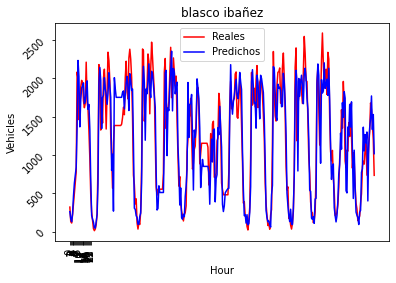

ATA ------->  A50
-------------------- ACABA AQUI, CALLE NUEVA -----------------------
Train Score: 0.10912 RMSE
Train Score: 0.07628 MAE
Train Score: 0.01191 MSE
Test Score: 0.10660 RMSE
Test Score: 0.07755 MAE
Test Score: 0.01136 MSE
Test Score: 17.26578 MAPE
Test Score: 16.75620 sMAPE


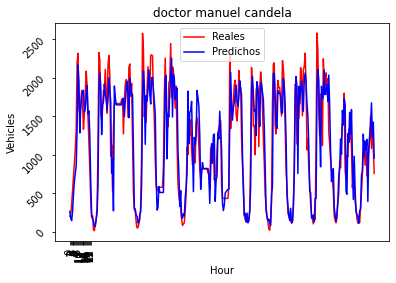

ATA ------->  A92
-------------------- ACABA AQUI, CALLE NUEVA -----------------------
Train Score: 0.09963 RMSE
Train Score: 0.06959 MAE
Train Score: 0.00993 MSE
Test Score: 0.11640 RMSE
Test Score: 0.08377 MAE
Test Score: 0.01355 MSE
Test Score: 31.89848 MAPE
Test Score: 23.97838 sMAPE


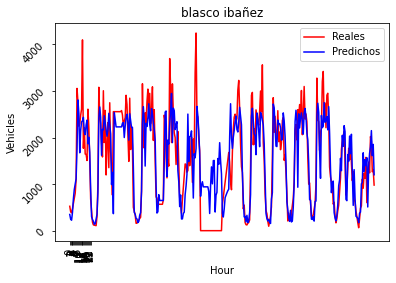

ATA ------->  A47
-------------------- ACABA AQUI, CALLE NUEVA -----------------------
Train Score: 0.09638 RMSE
Train Score: 0.06889 MAE
Train Score: 0.00929 MSE
Test Score: 0.09914 RMSE
Test Score: 0.07682 MAE
Test Score: 0.00983 MSE
Test Score: 16.42549 MAPE
Test Score: 16.45977 sMAPE


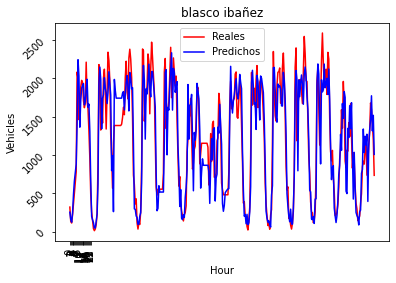

ATA ------->  A50
-------------------- ACABA AQUI, CALLE NUEVA -----------------------
Train Score: 0.08329 RMSE
Train Score: 0.05610 MAE
Train Score: 0.00694 MSE
Test Score: 0.08029 RMSE
Test Score: 0.05891 MAE
Test Score: 0.00645 MSE
Test Score: 16.53242 MAPE
Test Score: 15.97992 sMAPE


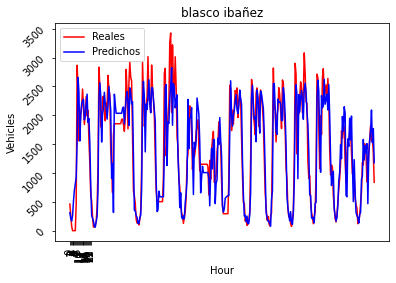

ATA ------->  A49
-------------------- ACABA AQUI, CALLE NUEVA -----------------------
Total train Score: 0.4848 RMSE
Total train Score: 0.3396 MAE
Total train Score: 0.0473 MSE
Total test Score: 0.5019 RMSE
Total test Score: 0.3743 MAE
Total test Score: 0.0511 MSE
Total test Score: 188.2951 MSE
AVG train Score: 0.0970 RMSE
AVG train Score: 0.0679 MAE
AVG train Score: 0.0095 MSE
AVG test Score: 0.1004 RMSE
AVG test Score: 0.0749 MAE
AVG test Score: 0.0102 MSE
AVG test Score: 37.6590 MAPE


In [18]:
# Make predictions and show them

# Change the path
path = "/content/drive/MyDrive/datos_web/otros/0.0001-24-mae/weights.best.hdf5"
model.load_weights(path)

# # make predictions
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
val_predict = model.predict(x_val)

# print(train_predict.shape)
train_predict_inversed = scaler.inverse_transform(train_predict)
test_predict_inversed = scaler.inverse_transform(test_predict)  
val_predict_inversed = scaler.inverse_transform(val_predict)  

y_test_inversed = scaler.inverse_transform(y_test)  
y_train_inversed = scaler.inverse_transform(y_train)
y_val_inversed = scaler.inverse_transform(y_val)

total_train_rmse = 0
total_train_mae = 0
total_train_mse = 0

total_test_rmse = 0
total_test_mae = 0
total_test_mse = 0
total_test_mape = 0

for i in range(test_predict.shape[1]):
  train_score = math.sqrt(mean_squared_error(y_train[:, i], train_predict[:,  i]))
  train_mse_score = mean_squared_error(y_train[:, i], train_predict[:,  i])
  train_mae_score = mean_absolute_error(y_train[:, i], train_predict[:,  i])

  print('Train Score: %.5f RMSE' % (train_score))
  print('Train Score: %.5f MAE' % (train_mae_score))
  print('Train Score: %.5f MSE' % (train_mse_score))

  total_train_rmse += train_score
  total_train_mae += train_mae_score
  total_train_mse += train_mse_score

  test_score = math.sqrt(mean_squared_error(y_test[:, i], test_predict[:,  i]))
  test_mae_score = mean_absolute_error(y_test[:, i], test_predict[:,  i])
  test_mse_score = mean_squared_error(y_test[:, i], test_predict[:,  i])
  test_mape_score = calc_mape(y_test[:, i], test_predict[:,  i])
  test_smape_score = calc_smape(y_test[:, i], test_predict[:,  i])
  print('Test Score: %.5f RMSE' % (test_score))
  print('Test Score: %.5f MAE' % (test_mae_score))
  print('Test Score: %.5f MSE' % (test_mse_score))
  print('Test Score: %.5f MAPE' % (test_mape_score))
  print('Test Score: %.5f sMAPE' % (test_smape_score))
  total_test_rmse += test_score
  total_test_mae += test_mae_score
  total_test_mse += test_mse_score
  total_test_mape += test_mape_score
  total_test_mape += test_smape_score
  fig, ax = plt.subplots()
  predicted_values = test_predict_inversed[:, i]
  real_values = y_test_inversed[:, i]
  horas = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
           20, 21, 22, 23]
  # ax.plot(horas, real_values[24:48], "-x", color = 'red', label = 'Real')
  # ax.plot(horas, predicted_values[24:48], "-x", color = 'blue', label = 'Forecasted')
  ax.plot(real_values, color = 'red', label = 'Reales')
  ax.plot(predicted_values, color = 'blue', label = 'Predichos')
  # ax.set_title(train_keys[i])
  if len(ordered_data[ordered_data.ATA==train_keys[i]]) > 0:
    name = ordered_data[ordered_data.ATA==train_keys[i]].desc.iloc[0]
  else:
    name = train_keys[i]
  ax.set_xlabel('Hour')
  ax.set_title(name)
  ax.tick_params(labelsize ='medium', pad = 5, direction = 'out', rotation = 45)
  ax.set_ylabel('Vehicles')
  ax.set_xticks(np.arange(len(horas)))
  ax.legend()
  plt.xticks(rotation='vertical')
  plt.show()
  print("ATA -------> ", train_keys[i])
  print("-------------------- ACABA AQUI, CALLE NUEVA -----------------------")
print('Total train Score: %.4f RMSE' % (total_train_rmse))
print('Total train Score: %.4f MAE' % (total_train_mae))
print('Total train Score: %.4f MSE' % (total_train_mse))

print('Total test Score: %.4f RMSE' % (total_test_rmse))
print('Total test Score: %.4f MAE' % (total_test_mae))
print('Total test Score: %.4f MSE' % (total_test_mse))
print('Total test Score: %.4f MSE' % (total_test_mape))


print('AVG train Score: %.4f RMSE' % (total_train_rmse / features))
print('AVG train Score: %.4f MAE' % (total_train_mae / features))
print('AVG train Score: %.4f MSE' % (total_train_mse / features))


print('AVG test Score: %.4f RMSE' % (total_test_rmse / features))
print('AVG test Score: %.4f MAE' % (total_test_mae / features))
print('AVG test Score: %.4f MSE' % (total_test_mse / features))
print('AVG test Score: %.4f MAPE' % (total_test_mape / features))



In [ ]:
y_test

array([[0.20665948, 0.1680644 , 0.20358531, 0.20665948, 0.19490266],
       [0.14378089, 0.17779268, 0.1802544 , 0.14378089, 0.15289757],
       [0.13709168, 0.2207313 , 0.17590457, 0.13709168, 0.11604018],
       ...,
       [0.56687355, 0.56927204, 0.35049102, 0.56687355, 0.43272552],
       [0.5013193 , 0.4605837 , 0.35958612, 0.5013193 , 0.37630695],
       [0.34546062, 0.35424355, 0.29354775, 0.34546062, 0.2725297 ]],
      dtype=float32)

In [ ]:
serie_test

,A50(t-1),A92(t-1),A47(t-1),A50(t-1),A49(t-1),A50(t),A92(t),A47(t),A50(t),A49(t),A50(t+1),A92(t+1),A47(t+1),A50(t+1),A49(t+1)
1,0.424059,0.430392,0.335069,0.424059,0.308975,0.310342,0.231801,0.250247,0.310342,0.229289,0.206659,0.168064,0.203585,0.206659,0.194903
2,0.310342,0.231801,0.250247,0.310342,0.229289,0.206659,0.168064,0.203585,0.206659,0.194903,0.143781,0.177793,0.180254,0.143781,0.152898
3,0.206659,0.168064,0.203585,0.206659,0.194903,0.143781,0.177793,0.180254,0.143781,0.152898,0.137092,0.220731,0.175905,0.137092,0.116040
4,0.143781,0.177793,0.180254,0.143781,0.152898,0.137092,0.220731,0.175905,0.137092,0.116040,0.174217,0.280443,0.193699,0.174217,0.100000
5,0.137092,0.220731,0.175905,0.137092,0.116040,0.174217,0.280443,0.193699,0.174217,0.100000,0.220038,0.339819,0.215646,0.220038,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,0.471887,0.451191,0.391221,0.471887,0.373630,0.538444,0.505200,0.345350,0.538444,0.422636,0.661860,0.603489,0.499572,0.661860,0.475142
333,0.538444,0.505200,0.345350,0.538444,0.422636,0.661860,0.603489,0.499572,0.661860,0.475142,0.632093,0.462261,0.480195,0.632093,0.421195
334,0.661860,0.603489,0.499572,0.661860,0.475142,0.632093,0.462261,0.480195,0.632093,0.421195,0.566874,0.569272,0.350491,0.566874,0.432726
335,0.632093,0.462261,0.480195,0.632093,0.421195,0.566874,0.569272,0.350491,0.566874,0.432726,0.501319,0.460584,0.359586,0.501319,0.376307


In [ ]:
test

,A50,A92,A47,A50,A49
2021-06-06 22:00:00,969.0,985.0,1189.0,969.0,1015.0
2021-06-06 23:00:00,629.0,393.0,760.0,629.0,628.0
2021-06-07 00:00:00,319.0,203.0,524.0,319.0,461.0
2021-06-07 01:00:00,131.0,232.0,406.0,131.0,257.0
2021-06-07 02:00:00,111.0,360.0,384.0,111.0,78.0
...,...,...,...,...,...
2021-06-20 19:00:00,1680.0,1501.0,2021.0,1680.0,1822.0
2021-06-20 20:00:00,1591.0,1080.0,1923.0,1591.0,1560.0
2021-06-20 21:00:00,1396.0,1399.0,1267.0,1396.0,1616.0
2021-06-20 22:00:00,1200.0,1075.0,1313.0,1200.0,1342.0


In [ ]:
test_predict_inversed[22:48, -1]

array([1470.7063 ,  645.7682 ,  190.20293,  156.30026,  131.02069,
         72.14755,   69.6858 ,  126.72035,  221.28201,  674.0538 ,
       2359.9717 , 2625.2554 , 2385.2861 , 1618.7672 , 2047.0803 ,
       2144.8142 , 2379.7058 , 2199.3018 , 2087.1697 , 2091.0488 ,
       2151.882  , 2460.2883 , 2245.467  , 2110.3516 ,  887.9845 ,
       1034.399  ], dtype=float32)

In [ ]:
test.iloc[24:48]

,A50,A92,A47,A50,A49
2021-06-07 22:00:00,959.0,825.0,1507.0,959.0,1163.0
2021-06-07 23:00:00,483.0,402.0,681.0,483.0,607.0
2021-06-08 00:00:00,254.0,186.0,446.0,254.0,519.0
2021-06-08 01:00:00,143.0,211.0,183.0,143.0,236.0
2021-06-08 02:00:00,37.0,31.0,124.0,37.0,63.0
2021-06-08 03:00:00,11.0,16.0,118.0,11.0,63.0
2021-06-08 04:00:00,32.0,90.0,113.0,32.0,105.0
2021-06-08 05:00:00,92.0,170.0,108.0,92.0,157.0
2021-06-08 06:00:00,229.0,320.0,309.0,229.0,419.0
2021-06-08 07:00:00,890.0,1091.0,1005.0,890.0,1106.0


In [ ]:
train_mse_score = mean_squared_error(y_train, train_predict)
print("TRAIN MSE", train_mse_score)
train_mae_score = mean_absolute_error(y_train, train_predict)
print("TRAIN MAE", train_mae_score)
train_rmse_score = math.sqrt(mean_squared_error(y_train, train_predict))
print("TRAIN RMSE", train_rmse_score)

val_mse_score = mean_squared_error(y_val, val_predict)
print("VAL MSE", val_mse_score)
val_mae_score = mean_absolute_error(y_val, val_predict)
print("VAL MAE", val_mae_score)
val_rmse_score = math.sqrt(mean_squared_error(y_val, val_predict))
print("VAL RMSE", val_rmse_score)

test_mse_score = mean_squared_error(y_test, test_predict)
print("TEST MSE", test_mse_score)
test_mae_score = mean_absolute_error(y_test, test_predict)
print("TEST MAE", test_mae_score)
test_rmse_score = math.sqrt(mean_squared_error(y_test, test_predict))
print("TEST RMSE", test_rmse_score)
test_mape_score = mape(y_test, test_predict)
print("TEST MAPE", test_mape_score)

TRAIN MSE 0.009439714
TRAIN MAE 0.06701798
TRAIN RMSE 0.09715819189830964
VAL MSE 0.012288949
VAL MAE 0.075400606
VAL RMSE 0.11085553415297138
TEST MSE 0.010419081
TEST MAE 0.07517223
TEST RMSE 0.10207389952980599
TEST MAPE tf.Tensor(20.030476, shape=(), dtype=float32)
